In [ ]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [12]:
!rm -r ~/.kaggle


rm: cannot remove '/root/.kaggle': No such file or directory


In [13]:
!mkdir ~/.kaggle


In [14]:
!mv ./kaggle.json ~/.kaggle/


mv: cannot stat './kaggle.json': No such file or directory


In [15]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [17]:
!kaggle datasets download -d rivaldo1233/reallife-trash-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/reallife-trash-dataset.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()



In [2]:
import os

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
from shutil import copyfile
import matplotlib.pyplot as plt

In [ ]:
source_path = '/content/Real_Life_Trashdataset'


source_path_Test = os.path.join(source_path, 'TEST')
source_path_Train = os.path.join(source_path, 'TRAIN')


In [ ]:
def train_val_generators(source_path_Train, source_path_Test):
 ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=source_path_Train,
                                                      batch_size=10,
                                                       class_mode='categorical',
                                                      target_size=(32, 32))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator( rescale = 1.0/255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=source_path_Test,
                                                                batch_size=5,
                                                                class_mode='categorical',
                                                                target_size=(32, 32))
#   ### END CODE HERE
  return train_generator, validation_generator

train_generator, validation_generator = train_val_generators(source_path_Train, source_path_Test)


Found 4000 images belonging to 4 classes.
Found 1035 images belonging to 4 classes.


In [ ]:
image_width, image_height = 255 , 255
batch_size_train = 20
batch_size_validation = 5
train_shuffle = tf.keras.preprocessing.image_dataset_from_directory(
    source_path_Train,
    shuffle = True,
    image_size = (image_width,image_height),
    batch_size = batch_size_train
)
validation_shuffle = tf.keras.preprocessing.image_dataset_from_directory(
    source_path_Test,
    shuffle = True,
    image_size = (image_width,image_height),
    batch_size = batch_size_validation
)



Found 4000 files belonging to 4 classes.
Found 1035 files belonging to 4 classes.


In [ ]:
class_names_train = train_shuffle.class_names
class_names_test = validation_shuffle.class_names
class_names_train
class_names_test

['Glass', 'Metal', 'Paper', 'Plastic']

images_train.shape:  (20, 255, 255, 3)
labels_train.shape:  (20,)


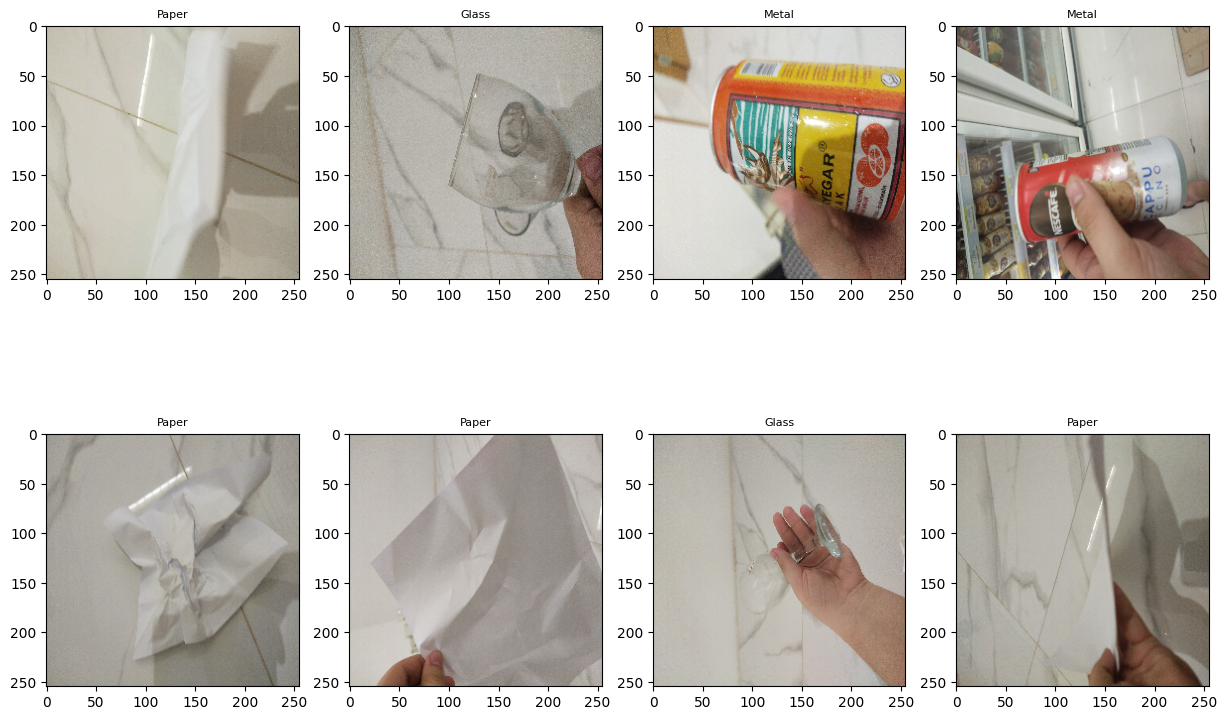

In [ ]:
plt.figure(figsize = (15,15))
for images_train, labels_train in train_shuffle.take(1):
  print('images_train.shape: ', images_train.shape)
  print('labels_train.shape: ', labels_train.shape)
  for i in range(8):
     ax = plt.subplot(3,4,i+1)
     plt.imshow(images_train[i].numpy().astype("int"))
     plt.title(class_names_train[labels_train[i]],fontsize = 8)


In [ ]:
train_dataset = train_shuffle.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_shuffle.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
augment = tf.keras.Sequential([
                     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
                     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])


In [ ]:
#train_dataset = train_dataset.map(
#    lambda x, y: (augment(x, training=True), y)
#).prefetch(buffer_size=tf.data.AUTOTUNE)

# Define preprocessing functions
def preprocess_images(images, labels):
    # Normalize pixel values to be between 0 and 1
    images = images / 255.0
    return images, labels

def preprocess_labels(images, labels):
    # One-hot encode labels
    labels_one_hot = tf.one_hot(labels, depth=len(class_names_train))
    return images, labels_one_hot

# Apply preprocessing to the datasets
train_dataset = train_dataset.map(preprocess_images).map(preprocess_labels)
validation_dataset = validation_dataset.map(preprocess_images).map(preprocess_labels)


In [ ]:
input_shape_transfer = (image_width,image_height,3)
transfer_model = tf.keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape_transfer,
)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            val_acc = logs["val_accuracy"]
            if val_acc > 0.50:
                print("\nReached 80% accuracy so cancelling training!")

                # Stop training once the above condition is met
                self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [ ]:
num_classes = len(class_names_train)

model = tf.keras.models.Sequential([
  transfer_model,
  tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes, activation='softmax'),
])
model.build(input_shape = (batch_size_train,image_width,image_height,3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 conv2d_189 (Conv2D)         (None, 4, 4, 64)          1179712   
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 64)          0         
                                                                 
 global_average_pooling2d_1  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                      

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
for images, labels in train_dataset.take(1):
    print('Shape of labels before one-hot encoding:', labels.shape)

Shape of labels before one-hot encoding: (20, 4)


In [ ]:

history = model.fit(train_dataset,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_dataset,
                    callbacks=[callbacks]
                    )

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9962
Reached 80% accuracy so cancelling training!
200/200 [==============================] - 57s 283ms/step - loss: 0.0139 - accuracy: 0.9962 - val_loss: 0.0063 - val_accuracy: 0.9971


In [16]:
import numpy as np
from google.colab import files
from keras.preprocessing import image


def preprocess_image(path_image):
    image = tf.keras.preprocessing.image.load_img(path_image, target_size=(255, 255))
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = image_array / 255.0  # Normalize pixel values
    return np.expand_dims(image_array, axis=0)  # Add batch dimension
uploaded = files.upload()

for fn in uploaded.keys():

  process_image = preprocess_image(fn)

  predictions = model.predict(process_image, batch_size=10)
  img = image.load_img(fn, target_size=(255, 255))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  print(f"File: {fn}")
  print(class_names_train)
  print("Predictions:", predictions)

Saving metal_9.jpg to metal_9.jpg


NameError: ignored

In [ ]:
model.save('/content/my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import zipfile
with zipfile.ZipFile('/content/my_model.zip', 'w') as zipf:
    zipf.write('/content/my_model.h5', 'my_model.h5')

In [ ]:
from google.colab import files

# Download the zip file
files.download('/content/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>